In [1]:
from pyrtid.inverse.regularization import (
    FFTCovarianceMatrix,
    eigen_factorize_cov_mat,
    LinearDriftMatrix,
    SparseInvCovarianceMatrix,
    get_prior_eigen_factorization,
)
from pyrtid.inverse.solvers.pcga.pcga import PCGA
import numpy as np
from pyrtid.utils import spde
from pyrtid.inverse.regularization.covariances import eigen_factorize_cov_mat
from sksparse.cholmod import cholesky
from pyrtid.utils.types import NDArrayFloat
import matplotlib.pyplot as plt

In [2]:
nx = 65
ny = 65
nz = 1
dx = 5.0
dy = 5.0
dz = 1.0
prior_std = 2.0
len_scale = 20.0  # m
kappa = 1 / len_scale
alpha = 1.0

mean = 50.0  # trend of the field
std = 20.0  # standard deviation of the field

# Create a precison matrix
Q_ref = spde.get_precision_matrix(
    nx, ny, nz, dx, dy, dz, kappa, alpha, spatial_dim=2, sigma=std
)
cholQ_ref = cholesky(Q_ref)
# Non conditonal simulation -> change the random state to obtain a different field
simu_ = spde.simu_nc(cholQ_ref, random_state=2026).reshape(ny, nx).T
s_ref = np.abs(simu_ + mean)

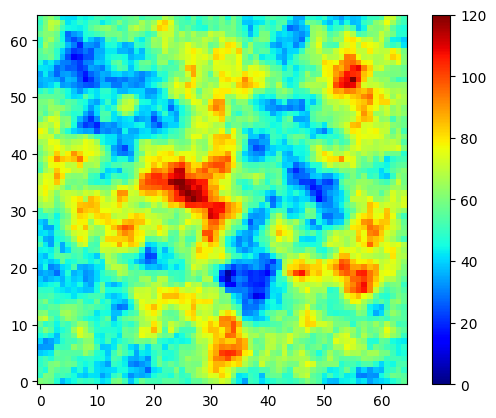

In [3]:
plt.imshow(
    s_ref.T,
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
    vmin=0.0,
    vmax=120,
)
plt.colorbar()

- Define a non linear model

In [4]:
from scipy.ndimage import gaussian_filter

In [5]:
def forward_model(x) -> NDArrayFloat:
    # return gaussian_filter(np.sqrt(x), sigma=2.0) - 0.1 * gaussian_filter(x ** 2 + 200, sigma=5.0)
    return gaussian_filter(4.0 * x**2, sigma=2.0)

In [6]:
d_ref = forward_model(s_ref)

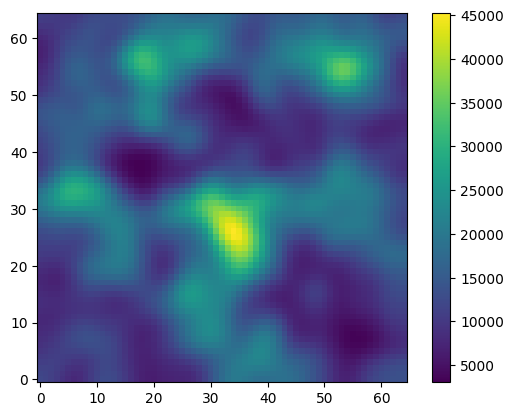

In [7]:
plt.imshow(
    d_ref,
    origin="lower",
    aspect="equal",
)
plt.colorbar()

In [8]:
simu_ = spde.simu_nc(cholQ_ref, random_state=15653).reshape(ny, nx).T
s_init = np.abs(simu_)

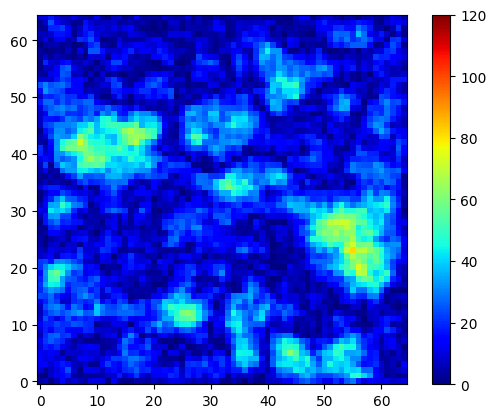

In [9]:
plt.imshow(
    s_init.T,
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
    vmin=0.0,
    vmax=120,
)
plt.colorbar()

In [10]:
d_init = forward_model(s_init)

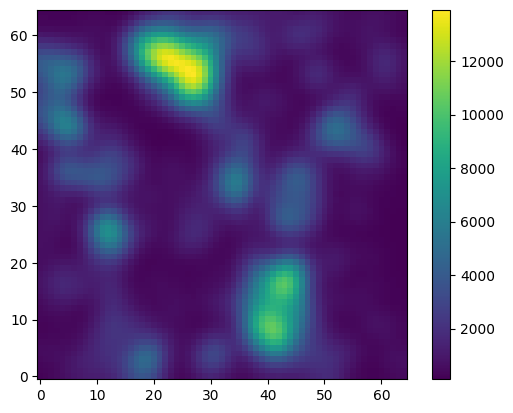

In [11]:
plt.imshow(
    d_init,
    origin="lower",
    aspect="equal",
)
plt.colorbar()

- We create a sampling function

In [12]:
percent_of_values = 0.05


def sample_d(d) -> NDArrayFloat:
    return d.ravel("F")[:: int(d.size / (percent_of_values * 1000))]

In [13]:
obs = sample_d(d_ref)
obs.shape

(51,)

In [14]:
obs

array([11958.37693777,  8017.53436771, 13203.27742952, 10558.80874659,
        9206.9631115 , 24365.46644938, 14812.44010934, 10619.49645516,
       16952.23568171, 11563.31769144, 12254.54580909,  9056.56999316,
       11280.34327842, 19177.7146164 ,  7171.77405879, 13861.95455012,
       18708.98554003, 19013.8034939 , 15289.04645837,  7423.66748811,
       21769.87255779, 20875.03491986, 27484.76150441,  9126.04184511,
       15706.97172203, 25705.75474337, 10377.41188314, 15487.41635457,
       12537.26770482, 30372.38441337, 13076.12388603, 21862.10914423,
       19441.08530439,  8011.12373843, 17711.75695241,  7545.1647571 ,
       16816.63431471, 18864.70759194,  8073.53810918, 17399.63716041,
       10322.3533716 , 16038.26198369,  7448.4913507 , 19275.70195618,
       29185.15179045,  5718.1633598 , 18176.59010999, 12708.05698174,
       12821.61512894, 17259.85717909,  9456.34985531])

In [15]:
# 10% error on the observations
cov_obs = (np.ones(obs.shape) * (np.max(obs) - np.min(obs)) * 0.1) ** 2

- Factorize the covariance matrix

In [16]:
sp_cov = SparseInvCovarianceMatrix(Q_ref)

eig_mat = eigen_factorize_cov_mat(sp_cov, n_pc=50)

assert eig_mat.number_pts == 4225

- Create a forward model

In [17]:
def forward_model_wrapper(s_ensemble, *args, **kargs) -> NDArrayFloat:
    d_pred = np.zeros((obs.size, s_ensemble.shape[1]))
    for i in range(s_ensemble.shape[1]):
        # use preconditionning
        res = forward_model(s_ensemble[:, i].reshape(nx, ny, order="F"))
        d_pred[:, i] = sample_d(res)
    return d_pred


# test
s_ens = np.vstack([s_ref.ravel("F"), s_init.ravel("F")]).T
assert s_ens.shape == (nx * ny, 2)

d_pred = forward_model_wrapper(s_ens)
assert d_pred.shape == (obs.size, 2)

np.testing.assert_almost_equal(d_pred[:, 0], obs)

In [18]:
obs_perturb = obs + np.random.default_rng(2151).normal(loc=0, scale=np.sqrt(cov_obs))

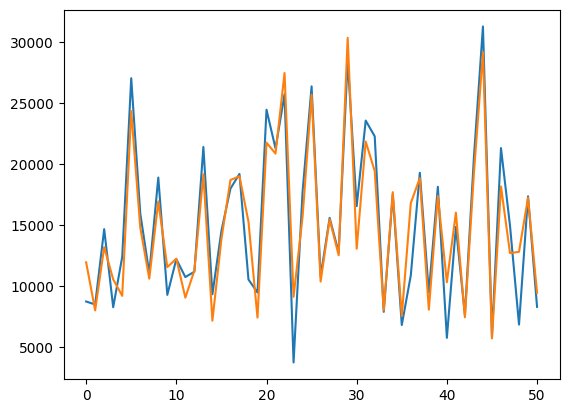

In [19]:
plt.plot(obs_perturb)
plt.plot(obs)

In [20]:
np.std(np.sqrt(s_init.ravel("F")))

1.7121586037933985

In [21]:
np.sqrt(150)

12.24744871391589

In [22]:
cov_obs.shape

(51,)

In [23]:
cov_obs

array([6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329,

In [54]:
solver = PCGA(
    s_init.ravel("F"),
    obs_perturb,
    cov_obs,
    forward_model_wrapper,
    eig_mat,
    maxiter=5,
    is_use_preconditioner=True,
    is_lm=False,
    is_direct_solve=False,
    prior_s_var=std**2,
    random_state=12,
    is_verbose=True,
    post_cov_estimation="diagonal",
)

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
  Number of unknowns                            : 4225
  Number of observations                        : 51
  Number of principal components (n_pc)         : 50
  Maximum Gauss-Newton iterations               : 5
  Machine eps (delta = sqrt(eps))               : 1e-08
  Tol for iterations (norm(sol_diff)/norm(sol)) : 0.01
  Levenberg-Marquardt (is_lm)                   : False
  Posterior covariance computation              : diagonal
  Line search                                   : False
-----------------------------------------------------------


In [55]:
assert solver.s_dim == nx * ny
assert solver.d_dim == obs.size

In [56]:
solver.drift.mat

array([[0.01538462],
       [0.01538462],
       [0.01538462],
       ...,
       [0.01538462],
       [0.01538462],
       [0.01538462]])

In [57]:
solver.prior_s_var

array([400., 400., 400., ..., 400., 400., 400.])

In [58]:
solver.cov_obs

array([6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329, 6078306.15758329, 6078306.15758329,
       6078306.15758329,

In [59]:
s_hat, simul_obs, post_diagv, iter_best = solver.run()

##### 2. Start PCGA Inversion #####
-- evaluate initial solution
- obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 14827.64594252373
- normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 6.014242311815493
***** Iteration 1 ******
computed Jacobian-Matrix products in 0.064163 secs
time for data covarance construction : 0.008897 sec 
eig. val. of data covariance (9.53e+00, 1.10e-03, 9.53e+00)
solve saddle point (co-kriging) system
-- Number of iterations for gmres 1
0 - min(s): 45, max(s) :194.226
evaluate the best solution
0-th solution obj 10050.709434866169 (alpha 1.0, beta [7848.163659440633])
- Geostat. inversion at iteration 1 is 0 sec
== iteration 1 summary ==
= objective function is 1.005071e+04, relative L2-norm diff btw sol 0 and sol 1 is 4.77433
= obs. RMSE is 48778.7, obs. normalized RMSE is 19.7851
***** Iteration 2 ******
computed Jacobian-Matrix products in 0.064694 secs
time for data covarance construction : 0.006446 sec 
eig. val. of data covariance (1.60e+02, 1.13e-01, 1

posterior diag. computed in 2.410852 secs
------------ Inversion Summary ---------------------------
** Found solution at iteration 5
** Solution obs. RMSE 1430.54 , initial obs. RMSE 14827.6, where RMSE = (norm(obs. diff.)/sqrt(nobs)), Solution obs. nRMSE 0.58024, init. obs. nRMSE 6.01424
** Final objective function value is 29.025505157109052
** Final predictive model checking Q2, cR is 1.161168e+00, 3.971788e+07
** Total elapsed time is 2.9674999713897705 secs
----------------------------------------------------------


In [60]:
def forward_model_single(s, is_parallel: bool = False, ncores: int = 5) -> NDArrayFloat:
    # use preconditionning
    res = forward_model(s.reshape(nx, ny, order="F"))
    return sample_d(res)

In [61]:
from pyPCGA import PCGA as PCGA_OLD

In [62]:
xmin: NDArrayFloat = np.array([0.5 * dx, 0.5 * dy])
xmax: NDArrayFloat = np.array([(nx - 0.5) * dx, (ny - 0.5) * dy])

solver_kwargs = {
    "R": cov_obs[0],
    "n_pc": 50,
    "maxiter": 5,
    "restol": 0.01,
    "matvec": "none",
    "xmin": xmin,
    "xmax": xmax,
    "N": np.array((nx, ny), dtype=np.int8),
    "prior_std": std,  # 150 ppm
    "prior_cov_scale": np.array([1 / kappa, 1 / kappa]),
    "kernel": lambda x: 0.0,
    "post_cov": "diag",
    "precond": True,
    "LM": False,
    "parallel": True,
    "linesearch": False,
    "forward_model_verbose": False,
    "verbose": True,
    "iter_save": True,
    "priorU": eig_mat.eig_vects,
    "priord": eig_mat.eig_vals,
    "direct": False,
}

solver_old = PCGA_OLD(
    forward_model_wrapper,
    s_init.ravel("F"),
    None,
    solver_kwargs,
    obs=obs_perturb,
    random_state=12,
)

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                               : 4225
   Number of observations                           : 51
   Number of principal components (n_pc)            : 50
   Prior model                                      :     "kernel": lambda x: 0.0,

   Prior variance                                   : 4.000000e+02
   Prior scale (correlation) parameter              : [20. 20.]
   Posterior cov computation                        : diag
   Posterior variance computation                   : Direct
   Number of CPU cores (n_core)                     : 4
   Maximum GN iterations                            : 5
   machine precision (delta = sqrt(precision))      : 1.000000e-08
   Tol for iterations (norm(sol_diff)/norm(sol))    : 1.000000e-02
   Levenberg-Marquardt (LM)                         : False
   Line search                                

In [63]:
s_hat_old, simul_obs_old, post_diagv_old, iter_best_old = solver_old.Run()

##### 4. Start PCGA Inversion #####
-- evaluate initial solution
obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 14827.6, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 6.01424
***** Iteration 1 ******
computed Jacobian-Matrix products in 0.081575 secs
eig. val. of generalized data covariance : 0.015099 secs (9.02e+01, 9.02e+01, 7.04e+03)
time for data covarance construction : 0.008593 sec 
eig. val. of data covariance (9.53e+00, 1.10e-03, 9.53e+00)
solve saddle point (co-kriging) system
-- Number of iterations for gmres 1
0 - min(s): 45, max(s) :194.226
evaluate the best solution
0-th solution obj [10050.70943487] (alpha 1.0, beta [7848.163659440633])
- Geostat. inversion at iteration 1 is 0 sec
== iteration 1 summary ==
= objective function is 1.005071e+04, relative L2-norm diff btw sol 0 and sol 1 is 4.77433
= obs. RMSE is 48778.7, obs. normalized RMSE is 19.7851
- save results in text at iteration 1
***** Iteration 2 ******
computed Jacobian-Matrix products in 0.059440 secs
eig

***** Iteration 5 ******
computed Jacobian-Matrix products in 0.073124 secs
eig. val. of generalized data covariance : 0.014327 secs (5.55e+02, 5.55e+02, 1.41e+04)
time for data covarance construction : 0.007493 sec 
eig. val. of data covariance (3.89e+01, 2.90e-02, 3.89e+01)
solve saddle point (co-kriging) system
-- Number of iterations for gmres 1
0 - min(s): 27.7197, max(s) :100.919
evaluate the best solution
0-th solution obj [29.02550516] (alpha 1.0, beta [3493.5311609852315])
- Geostat. inversion at iteration 5 is 0 sec
== iteration 5 summary ==
= objective function is 2.902551e+01, relative L2-norm diff btw sol 4 and sol 5 is 0.00114293
= obs. RMSE is 1430.54, obs. normalized RMSE is 0.58024
- save results in text at iteration 5
start direct posterior variance computation - this option works for O(nobs) ~ 100
[[ 7.81485620e+06  1.27380756e+05 -1.99798110e+05 ... -8.98421007e+04
   1.45561597e+05  6.57233056e+00]
 [ 1.27380756e+05  1.76378677e+07  3.11474009e+05 ... -4.72130306e+

In [64]:
solver_old.R

array([6078306.15758329])

In [65]:
solver_old.nopts_LM

4

- Comparision of observations

In [66]:
plt.plot(obs, label="ref")
plt.plot(simul_obs, label="new")
plt.plot(simul_obs_old, label="old")
plt.legend()

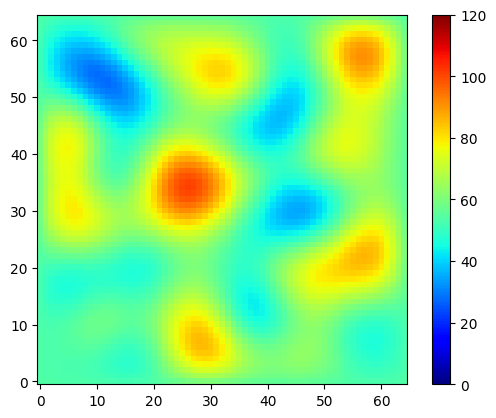

In [67]:
plt.imshow(
    s_hat.reshape(nx, ny, order="F").T,
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
    vmin=0.0,
    vmax=120,
)
plt.colorbar()

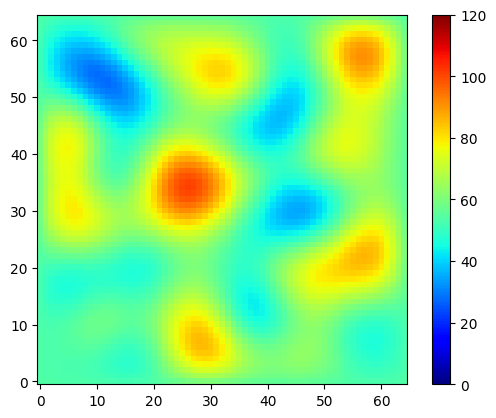

In [68]:
plt.imshow(
    s_hat_old.reshape(nx, ny, order="F").T,
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
    vmin=0.0,
    vmax=120,
)
plt.colorbar()

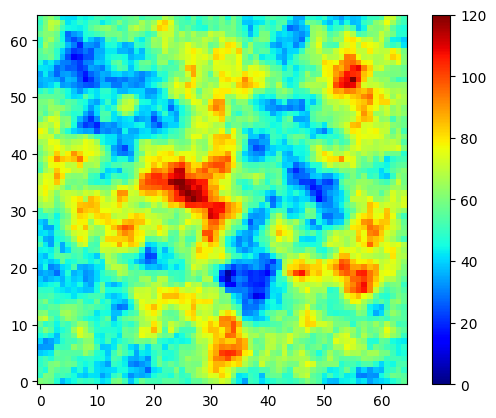

In [69]:
plt.imshow(
    s_ref.T,
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
    vmin=0.0,
    vmax=120,
)
plt.colorbar()

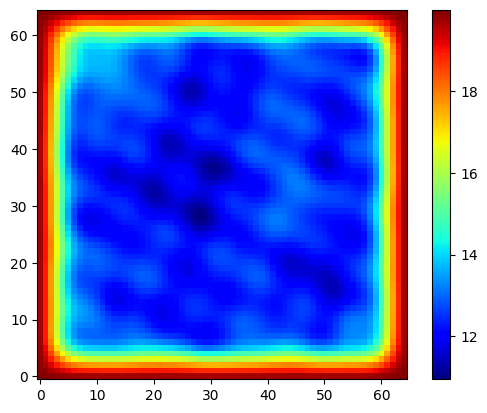

In [70]:
plt.imshow(
    np.sqrt(post_diagv.reshape(nx, ny, order="F").T),
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
    # vmin=50.0,
    # vmax=650,
)
plt.colorbar()

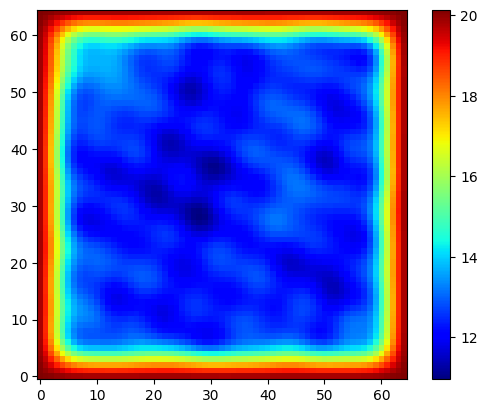

In [71]:
plt.imshow(
    np.sqrt(post_diagv_old.reshape(nx, ny, order="F").T),
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
    # vmin=50.0,
    # vmax=650,
)
plt.colorbar()

In [72]:
solver_old.prior_std

20.0